In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
x = np.arange(0, 300)
idx = pd.date_range('2018-01-01', periods = len(x))
season = pd.Series((x % 7) * 1.5, idx)
trend = pd.Series(x * 0.1, idx)
error = pd.Series(np.random.random(len(x)) * 7, idx)
y = season + trend + error

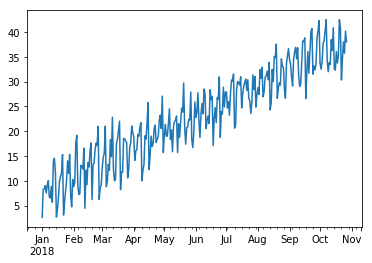

In [3]:
y.plot()

In [20]:
# Implement Loess

In [4]:
def tricubic_weight(u):
    """Tricubic-Weight-Funktion"""
    result = np.power(1 - np.power(u, 3), 3)
    result[np.abs(u) > 1] = 0
    return(result)

def loess_array(u, x, y, q = None, d = 2):
    """
    u - point to be estimated
    x - independent variable
    y - dependent variable
    q - cutting point
    d - the order of the local polynomial
    """
    n = len(x)
    if q is None:
        q = np.log(len(x))
    
    if q < n:
        idx = np.argsort(np.abs(u-x))[:q]
        x_reg = x[idx]
        y_reg = y[idx]
        weights = tricubic_weight(np.abs(u - x_reg) / np.max(np.abs(u - x_reg)))
        coeff = np.polyfit(x = x_reg, y = y_reg, deg = d, w = weights)
        result = np.poly1d(coeff)(u)
    elif q >= n:
        weights = tricubic_weight(np.abs(u - x) / (np.max(np.abs(u - x)) * q / n))
        coeff = np.polyfit(x = x, y = y, deg = d, w = weights)
        result = np.poly1d(coeff)(u)
    return(result)

def loess_series(u, series, q = None, d = 2):
    """
    u - point to be estimated
    x - independent variable
    y - dependent variable
    q - cutting point
    d - the order of the local polynomial
    """
    n = len(series)
    series.dropna(inplace = True)
    
    smoothed_series = pd.Series()
    
    for val in u:
        if q is None:
            q = int(2.5 * np.log(n))
    
        if q < n:
            idx = np.argsort(np.abs(val-series.index))[:q]
            x_reg = np.array((val - series.index[idx]).total_seconds())
            y_reg = series.values[idx]
            weights = tricubic_weight(np.abs(x_reg) / np.max(np.abs(x_reg)))
        elif q >= n:
            x_reg = np.array((val - series.index).total_seconds())
            y_reg = series.values
            weights = tricubic_weight(np.abs(x_reg) / (np.max(np.abs(x_reg)) * q / n))
    
        coeff = np.polyfit(x = x_reg, y = y_reg, deg = d, w = weights)
        smoothed_series[val] = np.poly1d(coeff)(0)
    return(smoothed_series)

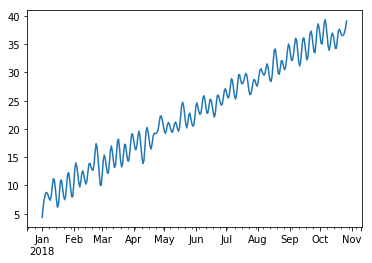

In [6]:
y_smooth = loess_series(idx, y) 
y_smooth.plot()

# Implementing STL

In [7]:
# Sub-Cycle Smoothing
def subcycle_smoothing(series, n_p = 7, n_s = 5, n_i = 1, n_o = 10):
    
    start = min(series.index) - n_p
    end = max(series.index) + n_p
    idx = pd.DatetimeIndex(freq = series.index.inferred_freq, start = start, end = end)
    series_expanded = series.copy().reindex(idx)
    
    
    for cycle in range(n_p):
        #slice_idx = slice(cycle, len(series_expanded), n_p) 
        #points = np.arange(start = - n_p, stop = len(idx) + n_p, step = n_p)
        cycle_subseries = series_expanded.copy().iloc[cycle:len(series_expanded):n_p]
        new_cycle_subseries = loess_series(cycle_subseries.index, cycle_subseries, q = n_s, d = 1)
        series_expanded.update(new_cycle_subseries)
        
    return(series_expanded)

def lowpass_filtering(series, n_p, n_l):
    filtered_series = series.rolling(n_p, center = True).mean().dropna()
    filtered_series = filtered_series.rolling(n_p, center = True).mean().dropna()
    filtered_series = filtered_series.rolling(3, center = True).mean().dropna()
    
    filtered_series = loess_series(filtered_series.index, filtered_series, q = n_l, d = 1)
    
    return(filtered_series)

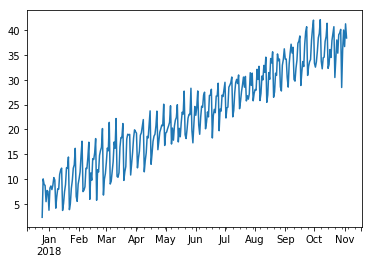

In [8]:
cycle = subcycle_smoothing(y)
cycle.plot()

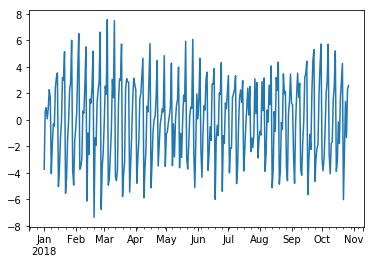

In [9]:
season_comp = cycle - lowpass_filtering(cycle, 7, 10)
season_comp.plot()

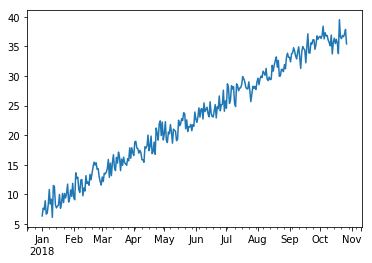

In [10]:
deseasonalized_series = y - season_comp
deseasonalized_series.plot()

In [11]:
trend = loess_series(deseasonalized_series.index, deseasonalized_series, q = 50, d = 1)
error = deseasonalized_series - trend

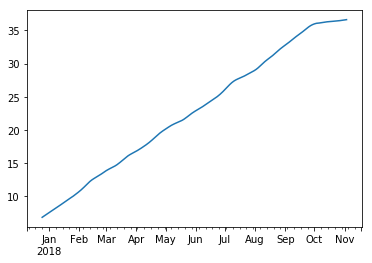

In [12]:
trend.plot()

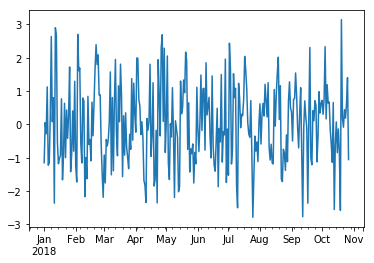

In [13]:
error.plot()

#ToDos
- put together different steps
- implement outer loop from paper
- implement heuristics
- check for usefulness of decomposition aka too many np.NaNs
- "copy" definitions of decomposition-class from stats-modul
- insert tests